<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">
 
# Running through the Random Forest
 


In [69]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

<a id="part-three"></a>
## Part 3: Random Forests

Random Forests offer a **slight variation on bagged trees** with even better performance:

- Exactly like bagging, we create an ensemble of decision trees using bootstrapped samples of the training set.
- However, when building each tree, each time a split is considered, a **random sample of m features** is chosen as split candidates from the **full set of p features**. The split is only allowed to use **one of those m features**.
    - A new random sample of features is chosen for **every single tree at every single split**.
    - For **classification**, m is typically chosen to be the square root of p.
    - For **regression**, m is typically chosen to be somewhere between p/3 and p.

What's the point?

- Suppose there is **one very strong feature** in the data set. When using bagged trees, most of the trees will use that feature as the top split, resulting in an ensemble of similar trees that are **highly correlated**.
- Averaging highly correlated quantities does not significantly reduce variance (which is the entire goal of bagging).
- By randomly leaving out candidate features from each split, **random forests "decorrelate" the trees** to the extent that the averaging process can reduce the variance of the resulting model.
- Another way of looking at it is that sometimes one or two strong features dominate every tree in bagging, resulting in essentially the same tree as every predictor. (This is what was meant when saying the trees could be highly correlated.) By using a subset of features to generate each tree, we get a wider variety of predictive trees that do not all use the same dominant features.

<a id="part-four"></a>
## Part 4: Building and Tuning Decision Trees and Random Forests

In this section, we will implement random forests in scikit-learn.

- Major League Baseball player data from 1986-87: [data](https://github.com/justmarkham/DAT8/blob/master/data/hitters.csv), [data dictionary](https://cran.r-project.org/web/packages/ISLR/ISLR.pdf) (page 7)
- Each observation represents a player.
- **Goal:** Predict player salary.

### Preparing the Data

In [79]:
# Read in the data.
path ='./data/hitters.csv'
hitters = pd.read_csv(path)

# Remove rows with missing values.
hitters = hitters.dropna()
hitters

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,League,Division,PutOuts,Assists,Errors,Salary,NewLeague
1,315,81,7,24,38,39,14,3449,835,69,321,414,375,N,W,632,43,10,475.0,N
2,479,130,18,66,72,76,3,1624,457,63,224,266,263,A,W,880,82,14,480.0,A
3,496,141,20,65,78,37,11,5628,1575,225,828,838,354,N,E,200,11,3,500.0,N
4,321,87,10,39,42,30,2,396,101,12,48,46,33,N,E,805,40,4,91.5,N
5,594,169,4,74,51,35,11,4408,1133,19,501,336,194,A,W,282,421,25,750.0,A
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
317,497,127,7,65,48,37,5,2703,806,32,379,311,138,N,E,325,9,3,700.0,N
318,492,136,5,76,50,94,12,5511,1511,39,897,451,875,A,E,313,381,20,875.0,A
319,475,126,3,61,43,52,6,1700,433,7,217,93,146,A,W,37,113,7,385.0,A
320,573,144,9,85,60,78,8,3198,857,97,470,420,332,A,E,1314,131,12,960.0,A


In [81]:
# Encode categorical variables as integers.
from sklearn.preprocessing import LabelEncoder
hitters = hitters.apply(LabelEncoder().fit_transform)
# df = pd.get_dummies(hitters.League, prefix='League')
# df1 = pd.get_dummies(hitters.Division, prefix = 'Division')
# hitters = pd.concat([hitters, df, df1], axis=1)
# hitters


In [37]:
# Alternative approach
#hitters['league'] =pd.factorize(hitters.League)[0]

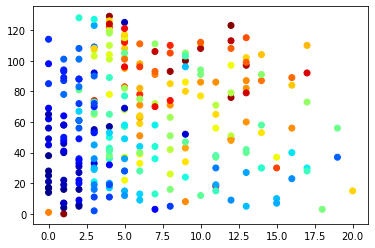

In [82]:
# Create a scatter plot of hits vs years, colored by salary
plt.scatter(hitters.Years, hitters.Hits, c = hitters.Salary,cmap='jet')

In [83]:
# Define features: Exclude career statistics (which start with "C") and the response (salary).
hitters_encoded = hitters.loc[:, ~hitters.columns.str.startswith('C')].drop('Salary', axis =1)
feature_cols = hitters_encoded.columns

hitters_encoded

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,League,Division,PutOuts,Assists,Errors,NewLeague
1,63,40,7,14,28,35,13,1,1,169,31,10,1
2,130,81,18,55,60,71,2,0,1,183,48,14,0
3,139,91,20,54,66,33,10,1,0,80,11,3,1
4,65,46,10,29,31,26,1,1,0,178,30,4,1
5,188,111,4,63,40,31,10,0,1,117,129,25,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
317,140,78,7,54,37,33,4,1,0,138,9,3,1
318,137,86,5,65,39,84,11,0,0,132,123,20,0
319,129,77,3,50,32,47,5,0,1,3,64,7,0
320,173,93,9,73,49,73,7,0,0,196,68,12,0


In [84]:
# Define X and y.
X=hitters_encoded[feature_cols]
y=hitters.Salary


<a id="decision-tree"></a>
## Predicting Salary With a Decision Tree

Let's first recall how we might predict salary using a single decision tree.

We'll first find the best **max_depth** for a decision tree using cross-validation:

In [92]:
# List of values to try for max_depth:
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_val_score

max_depth = list(range(1,21))
RMSE_scores = []

for depth in max_depth:
    tree_reg = DecisionTreeRegressor(max_depth=depth, random_state=1)
    MSE_scores = cross_val_score(tree_reg, X, y, cv=10, scoring= 'neg_mean_squared_error')
    RMSE_scores.append(np.sqrt(-MSE_scores))

    
RMSE_scores


    

# List to store the average RMSE for each value of max_depth:

# Use 10-fold cross-validation with each value of max_depth.


[array([28.89425602, 28.025562  , 37.83394585, 30.35645378, 36.69485905,
        31.56059872, 33.18882063, 33.19448422, 30.56885958, 32.45866479]),
 array([27.53581422, 21.92337715, 31.46399613, 22.82592659, 35.79680341,
        28.81289136, 34.13564136, 31.69962078, 32.46016472, 28.15317886]),
 array([26.81502607, 22.61428951, 29.13511569, 25.88037585, 38.00789656,
        27.122187  , 22.96718992, 34.8215466 , 33.25689713, 23.54432696]),
 array([27.51119631, 20.72401131, 34.13882226, 25.13800321, 36.38480005,
        26.7068949 , 21.29809872, 35.81213836, 36.93130403, 27.03969584]),
 array([28.69730506, 28.69678148, 33.49776836, 29.52882284, 36.38163189,
        27.35977943, 20.36664969, 34.62336114, 40.25163986, 27.39787105]),
 array([29.52266075, 33.96944571, 34.48491086, 28.7056236 , 40.12368574,
        28.02187419, 17.00552211, 35.83820177, 37.14693541, 31.01343228]),
 array([31.06113225, 29.72213468, 35.46297992, 28.00738989, 41.99083667,
        27.5744985 , 17.55069373, 34.36

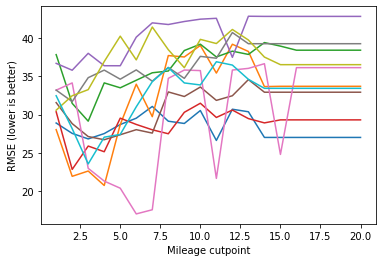

In [93]:
# Plot max_depth (x-axis) versus RMSE (y-axis).
plt.plot(max_depth, RMSE_scores);
plt.xlabel('Mileage cutpoint');
plt.ylabel('RMSE (lower is better)');

In [ ]:
# Show the best RMSE and the corresponding max_depth.


In [94]:
# max_depth=2 was best, so fit a tree using that parameter.
tree_final = DecisionTreeRegressor(max_depth=2, random_state=1)
tree_final.fit(X,y)

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=2,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=1, splitter='best')

In [97]:
# Compute feature importances.
final_score = cross_val_score(tree_final, X, y, cv = 10, scoring= 'neg_mean_squared_error')
final_mean = np.mean((np.sqrt(-final_score)))
final_mean

#

29.480741456901466

<a id="random-forest-demo"></a>
## Predicting Salary With a Random Forest

### Fitting a Random Forest With the Best Parameters

In [98]:
from sklearn.ensemble import RandomForestRegressor

In [103]:
# max_features=5 is best and n_estimators=150 is sufficiently large.
random_refg = RandomForestRegressor(n_estimators=150, max_features=5, random_state=1)
random_refg.fit(X,y)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features=5, max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=150, n_jobs=None, oob_score=False,
                      random_state=1, verbose=0, warm_start=False)

In [104]:
# Compute feature importances.
pd.DataFrame({'features':X.columns, 'importance': random_refg.feature_importances_})

,features,importance
0,AtBat,0.096399
1,Hits,0.136437
2,HmRun,0.040425
3,Runs,0.063227
4,RBI,0.095290
5,Walks,0.082314
6,Years,0.365434
7,League,0.004469
8,Division,0.005888
9,PutOuts,0.043842


In [108]:
# Compute the out-of-bag R-squared score.
random_refg.oob_score
# Find the average RMSE.
final_score_rf = cross_val_score(tree_final, X, y, cv = 10, scoring= 'neg_mean_squared_error')
final_mean_rf = np.mean((np.sqrt(-final_score_rf)))
final_mean_rf

29.480741456901466

#### Reducing X to its Most Important Features

In [ ]:
# Check the shape of X.


** It important not to select features before separating your train from your test otherwise you are selecting features based on all known observations and introducing more of the information in the test data to the model when you fit it on the training data. **

In [ ]:
from sklearn.model_selection import train_test_split


In [ ]:
# Fit the model on only the train data


In [ ]:
# Set a threshold for which features to include.
from sklearn.feature_selection import SelectFromModel



Using the fit model and the features from the train data to transform the test data

In [ ]:
# Create a new feature matrix that only includes important features.



In [ ]:
# Check the RMSE for a random forest that only includes important features.


In this case, the error decreased slightly. Often parameter tuning is required to achieve optimal results.

<a id="comparing"></a>
## Comparing Random Forests With Decision Trees

**Advantages of random forests:**

- Their performance is competitive with the best supervised learning methods.
- They provide a more reliable estimate of feature importance.
- They allow you to estimate out-of-sample error without using train/test split or cross-validation.

**Disadvantages of random forests:**

- They are less interpretable.
- They are slower to train.
- They are slower to predict.

![Machine learning flowchart](assets/driver_ensembling.png)

*Machine learning flowchart created by the [second-place finisher](http://blog.kaggle.com/2015/04/20/axa-winners-interview-learning-telematic-fingerprints-from-gps-data/) of Kaggle's [Driver Telematics competition](https://www.kaggle.com/c/axa-driver-telematics-analysis)*.

<a id="tuning"></a>
## Optional: Tuning Individual Parameters

In [100]:
from sklearn.ensemble import RandomForestRegressor
rfreg = RandomForestRegressor()
rfreg

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

### Tuning n_estimators

One important tuning parameter is **n_estimators**, which represents the number of trees that should be grown. This should be a large enough value that the error seems to have "stabilized."

In [109]:
# List of values to try for n_estimators:
estimator_range = list(range(10, 310, 10))

# List to store the average RMSE for each value of n_estimators:
RMSE_scores = []

# Use five-fold cross-validation with each value of n_estimators (Warning: Slow!).
for estimator in estimator_range:
    rfreg = RandomForestRegressor(n_estimators=estimator, random_state=1)
    MSE_scores = cross_val_score(rfreg, X, y, cv=5, scoring='neg_mean_squared_error')
    RMSE_scores.append(np.mean(np.sqrt(-MSE_scores)))

In [ ]:
# Plot RMSE (y-axis) versus n_estimators (x-axis).

plt.plot(estimator_range, RMSE_scores);

plt.xlabel('n_estimators');
plt.ylabel('RMSE (lower is better)');

_** In theory, the RMSE will continue to decrease and eventually level out.  Adding more estimators will neither (noticably)increase or decrease the RMSE (or other loss metric). However, introduction of noise can lead to random spikes as the n_estimators changes. This example is particularly interesting as after about 120 estimators the RMSE seems to steadily rise as more estimators are added.**_

### Tuning max_features

The other important tuning parameter is **max_features**, which represents the number of features that should be considered at each split.

In [ ]:
# List of values to try for max_features:
feature_range = list(range(1, len(feature_cols)+1))

# List to store the average RMSE for each value of max_features:
RMSE_scores = []

# Use 10-fold cross-validation with each value of max_features (Warning: Super slow!).
for feature in feature_range:
    rfreg = RandomForestRegressor(n_estimators=150, max_features=feature, random_state=1)
    MSE_scores = cross_val_score(rfreg, X, y, cv=10, scoring='neg_mean_squared_error')
    RMSE_scores.append(np.mean(np.sqrt(-MSE_scores)))

In [ ]:
# Plot max_features (x-axis) versus RMSE (y-axis).

plt.plot(feature_range, RMSE_scores);

plt.xlabel('max_features');
plt.ylabel('RMSE (lower is better)');

In [ ]:
# Show the best RMSE and the corresponding max_features.
sorted(zip(RMSE_scores, feature_range))[0]

<a id="summary"></a>
## Summary

**Which model is best?** The best classifier for a particular task is task-dependent. In many business cases, interpretability is more important than accuracy. So, decision trees may be preferred. In other cases, accuracy on unseen data might be paramount, in which case random forests would likely be better (since they typically overfit less). 

Remember that every model is a tradeoff between bias and variance. Ensemble models attempt to reduce overfitting by reducing variance but increasing bias (as compared to decision trees). By making the model more stable, we necessarily make it fit the training data less accurately. In some cases this is desired (particularly if we start with lots of overfitting), but for more simply structured data a simple decision tree might be best.

---

**In this lesson:**

- We looked at ensemble models.

- We saw how decision trees could be extended using two ensemble techniques -- bagging and random forests.

- We looked at methods of evaluating feature importance and tuning parameters.